In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV, StratifiedKFold


import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
# 1. CHARGEMENT DES DONNÉES
print("=== CHARGEMENT DES DONNÉES ===")

try:
    # Option 1: Via URL
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    df = pd.read_csv(url)
except:
    # Option 2: Via seaborn (si URL bloque)
    df = sns.load_dataset('titanic')
    # Renommer les colonnes pour correspondre au code
    df = df.rename(columns={'survived': 'Survived', 'pclass': 'Pclass', 'sex': 'Sex', 
                            'age': 'Age', 'sibsp': 'SibSp', 'parch': 'Parch', 
                            'fare': 'Fare', 'embarked': 'Embarked'})

print("\nPremières lignes:")
print(df.head())

=== CHARGEMENT DES DONNÉES ===

Premières lignes:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4    

In [57]:
# 2. EXPLORATION RAPIDE
print("\n=== EXPLORATION DES DONNÉES ===")

# Afficher la forme du dataset et les colonnes
print("\n")
print(f"Forme du dataset: {df.shape}")
print("\n")
print(f"Colonnes: {list(df.columns)}")

# Explorer les types de données et les valeurs manquantes
print("\n")
print("\nTypes de données et valeurs manquantes:")
print(df.info())

# Afficher les statistiques descriptives
print("\n")
print("Valeurs manquantes:")
print(df.isnull().sum())
print(f"\nTaux de survie: {df['Survived'].mean():.2%}")


=== EXPLORATION DES DONNÉES ===


Forme du dataset: (891, 12)


Colonnes: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']



Types de données et valeurs manquantes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Va


=== ANALYSE EXPLORATOIRE (EDA) ===
Statistiques descriptives:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


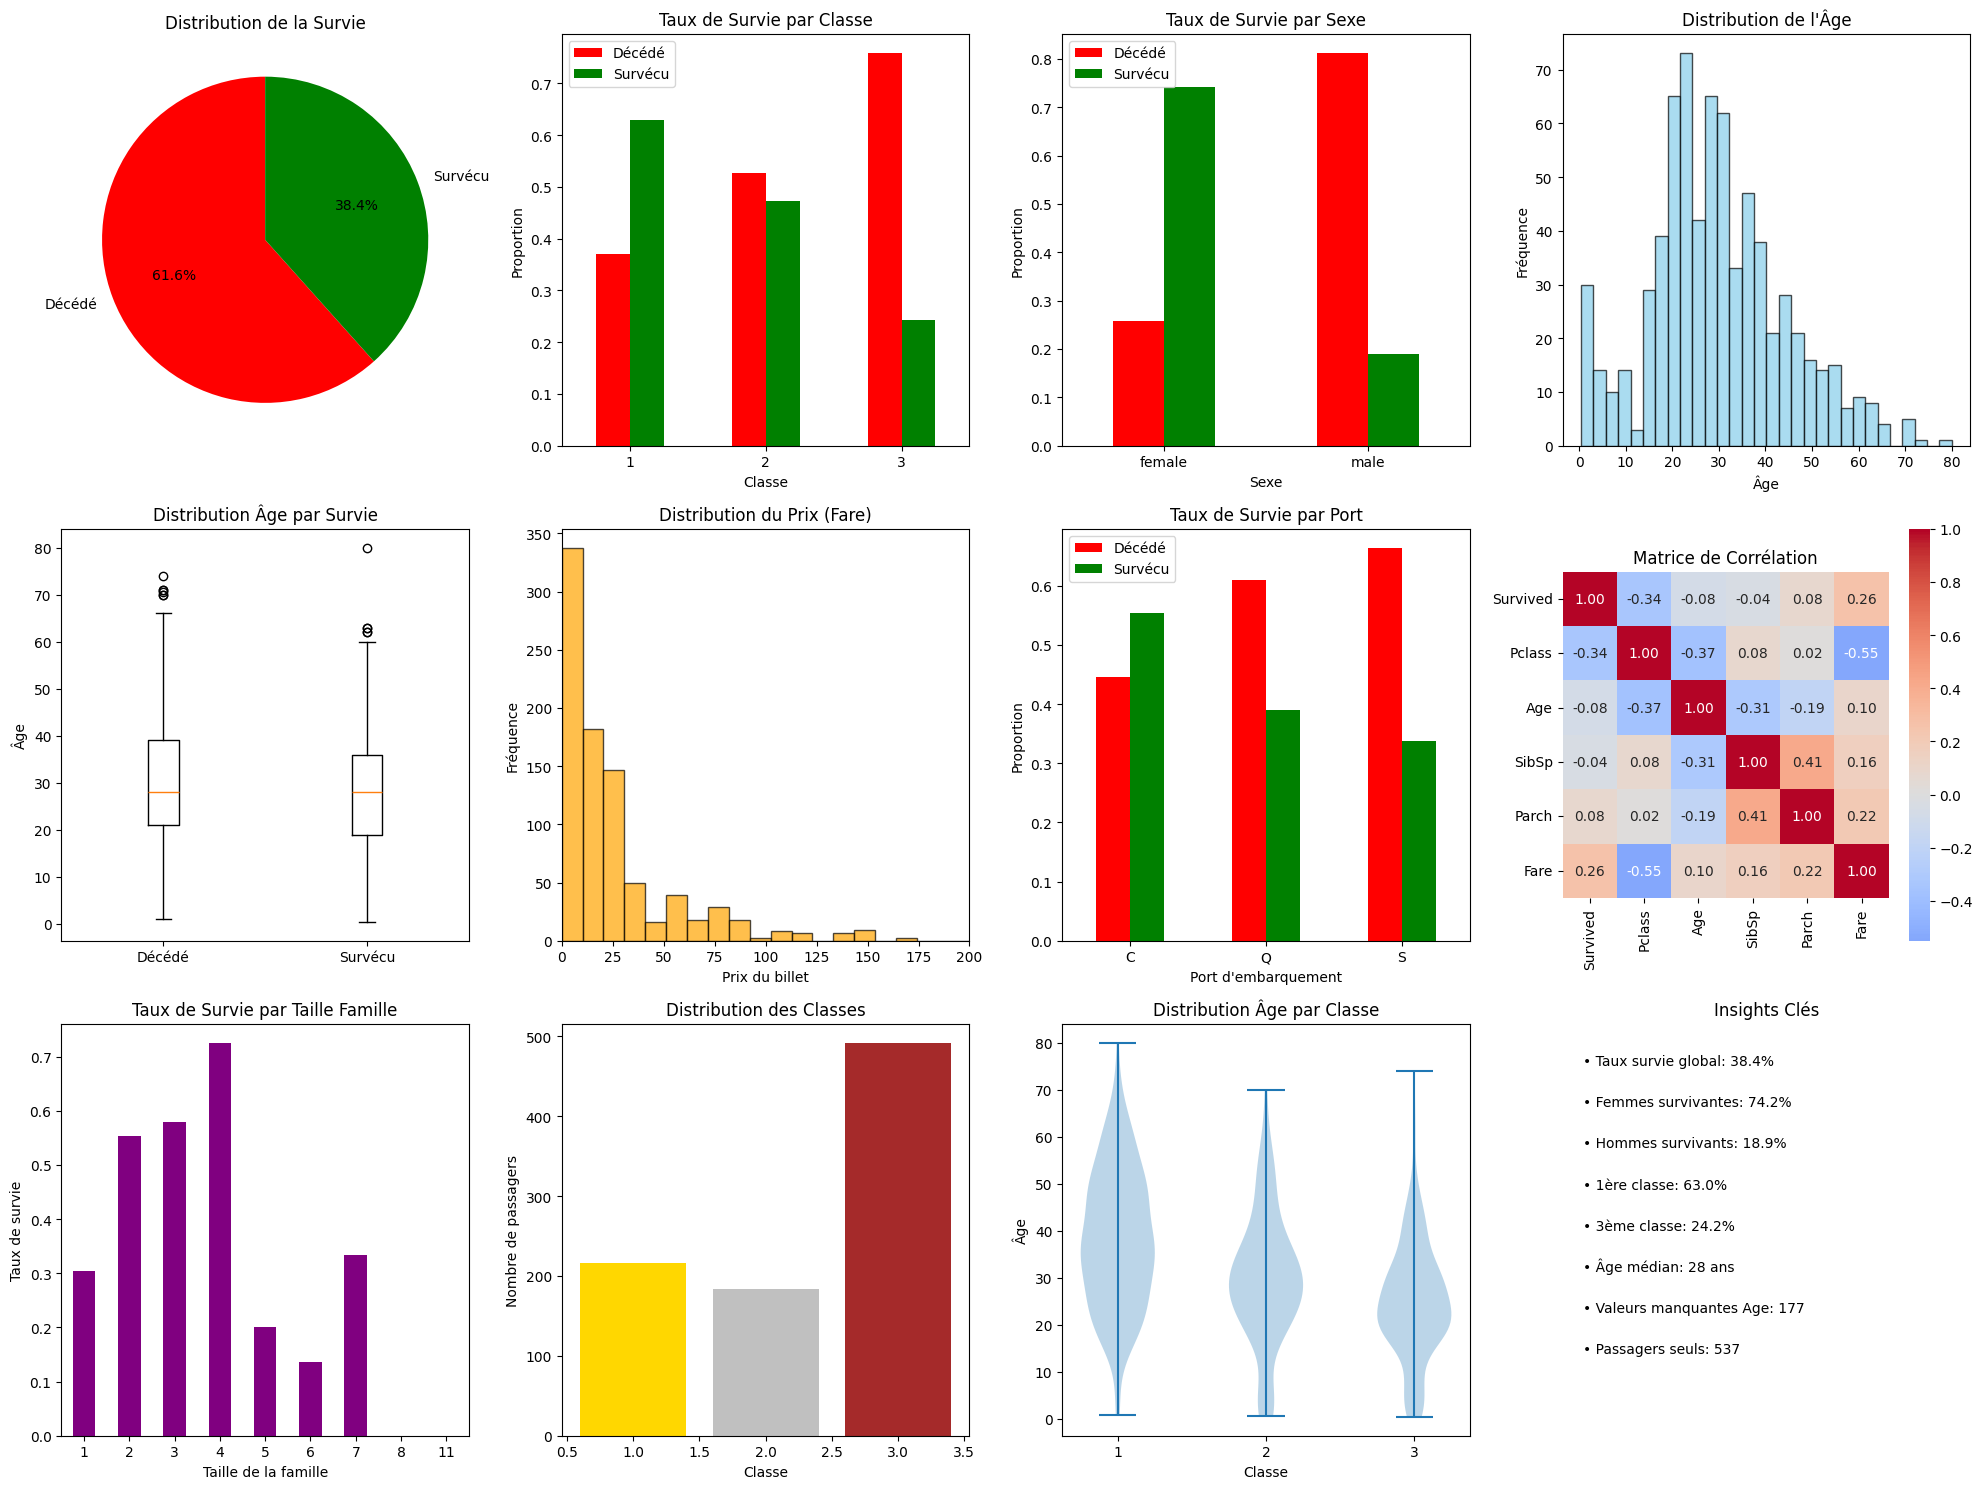


=== INSIGHTS DE L'EDA ===
🎯 Facteurs de survie identifiés:
   • Sexe: Les femmes ont 74.2% de survie vs 18.9% pour les hommes
   • Classe sociale: 1ère classe 63.0% vs 3ème classe 24.2%
   • Âge: Les survivants ont un âge médian de 28 ans

📊 Valeurs manquantes à traiter:
   • Age: 177 (19.9%)
   • Cabin: 687 (77.1%)
   • Embarked: 2 (0.2%)

🔍 Recommandations preprocessing:
   • Age: Imputer avec la médiane (28 ans)
   • Embarked: Imputer avec le mode ('S')
   • Feature engineering: Créer 'FamilySize' pourrait être utile


In [58]:
# 2.1 EDA - ANALYSE EXPLORATOIRE DÉTAILLÉE
print("\n=== ANALYSE EXPLORATOIRE (EDA) ===")

# Statistiques descriptives
print("Statistiques descriptives:")
print(df.describe())

# EDA Visualisations
plt.figure(figsize=(20, 15))

# 1. Distribution de la variable cible
plt.subplot(3, 4, 1)
survival_counts = df['Survived'].value_counts()
plt.pie(survival_counts.values, labels=['Décédé', 'Survécu'], autopct='%1.1f%%', 
        colors=['red', 'green'], startangle=90)
plt.title('Distribution de la Survie')

# 2. Survie par classe
plt.subplot(3, 4, 2)
survival_by_class = pd.crosstab(df['Pclass'], df['Survived'], normalize='index')
survival_by_class.plot(kind='bar', color=['red', 'green'], ax=plt.gca())
plt.title('Taux de Survie par Classe')
plt.xlabel('Classe')
plt.ylabel('Proportion')
plt.legend(['Décédé', 'Survécu'])
plt.xticks(rotation=0)

# 3. Survie par sexe
plt.subplot(3, 4, 3)
survival_by_sex = pd.crosstab(df['Sex'], df['Survived'], normalize='index')
survival_by_sex.plot(kind='bar', color=['red', 'green'], ax=plt.gca())
plt.title('Taux de Survie par Sexe')
plt.xlabel('Sexe')
plt.ylabel('Proportion')
plt.legend(['Décédé', 'Survécu'])
plt.xticks(rotation=0)

# 4. Distribution de l'âge
plt.subplot(3, 4, 4)
plt.hist(df['Age'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution de l\'Âge')
plt.xlabel('Âge')
plt.ylabel('Fréquence')

# 5. Survie par âge (boxplot)
plt.subplot(3, 4, 5)
survived_ages = df[df['Survived'] == 1]['Age'].dropna()
died_ages = df[df['Survived'] == 0]['Age'].dropna()
plt.boxplot([died_ages, survived_ages], tick_labels=['Décédé', 'Survécu'])
plt.title('Distribution Âge par Survie')
plt.ylabel('Âge')

# 6. Distribution du prix du billet
plt.subplot(3, 4, 6)
plt.hist(df['Fare'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution du Prix (Fare)')
plt.xlabel('Prix du billet')
plt.ylabel('Fréquence')
plt.xlim(0, 200)  # Zoom sur les valeurs principales

# 7. Survie par port d'embarquement
plt.subplot(3, 4, 7)
survival_by_port = pd.crosstab(df['Embarked'], df['Survived'], normalize='index')
survival_by_port.plot(kind='bar', color=['red', 'green'], ax=plt.gca())
plt.title('Taux de Survie par Port')
plt.xlabel('Port d\'embarquement')
plt.ylabel('Proportion')
plt.legend(['Décédé', 'Survécu'])
plt.xticks(rotation=0)

# 8. Heatmap des corrélations
plt.subplot(3, 4, 8)
# Sélection des variables numériques pour la corrélation
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Matrice de Corrélation')

# 9. Survie par taille de famille
plt.subplot(3, 4, 9)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
survival_by_family = df.groupby('FamilySize')['Survived'].mean()
survival_by_family.plot(kind='bar', color='purple', ax=plt.gca())
plt.title('Taux de Survie par Taille Famille')
plt.xlabel('Taille de la famille')
plt.ylabel('Taux de survie')
plt.xticks(rotation=0)

# 10. Distribution des classes
plt.subplot(3, 4, 10)
class_counts = df['Pclass'].value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values, color=['gold', 'silver', 'brown'])
plt.title('Distribution des Classes')
plt.xlabel('Classe')
plt.ylabel('Nombre de passagers')

# 11. Âge par classe (violin plot)
plt.subplot(3, 4, 11)
age_class_data = [df[df['Pclass'] == i]['Age'].dropna() for i in [1, 2, 3]]
plt.violinplot(age_class_data, positions=[1, 2, 3])
plt.title('Distribution Âge par Classe')
plt.xlabel('Classe')
plt.ylabel('Âge')
plt.xticks([1, 2, 3])

# 12. Insights textuels
plt.subplot(3, 4, 12)
insights = [
    f"• Taux survie global: {df['Survived'].mean():.1%}",
    f"• Femmes survivantes: {df[df['Sex']=='female']['Survived'].mean():.1%}",
    f"• Hommes survivants: {df[df['Sex']=='male']['Survived'].mean():.1%}",
    f"• 1ère classe: {df[df['Pclass']==1]['Survived'].mean():.1%}",
    f"• 3ème classe: {df[df['Pclass']==3]['Survived'].mean():.1%}",
    f"• Âge médian: {df['Age'].median():.0f} ans",
    f"• Valeurs manquantes Age: {df['Age'].isnull().sum()}",
    f"• Passagers seuls: {len(df[df['FamilySize']==1])}"
]

for i, insight in enumerate(insights):
    plt.text(0.05, 0.9 - i*0.1, insight, fontsize=10, transform=plt.gca().transAxes)
plt.title('Insights Clés')
plt.axis('off')

plt.tight_layout()
plt.show()

# Analyse textuelle des insights
print("\n=== INSIGHTS DE L'EDA ===")
print(f"🎯 Facteurs de survie identifiés:")
print(f"   • Sexe: Les femmes ont {df[df['Sex']=='female']['Survived'].mean():.1%} de survie vs {df[df['Sex']=='male']['Survived'].mean():.1%} pour les hommes")
print(f"   • Classe sociale: 1ère classe {df[df['Pclass']==1]['Survived'].mean():.1%} vs 3ème classe {df[df['Pclass']==3]['Survived'].mean():.1%}")
print(f"   • Âge: Les survivants ont un âge médian de {df[df['Survived']==1]['Age'].median():.0f} ans")

# Analyse des valeurs manquantes
missing_analysis = df.isnull().sum()
missing_pct = (missing_analysis / len(df)) * 100
print(f"\n📊 Valeurs manquantes à traiter:")
for col, count in missing_analysis[missing_analysis > 0].items():
    print(f"   • {col}: {count} ({missing_pct[col]:.1f}%)")

print(f"\n🔍 Recommandations preprocessing:")
print(f"   • Age: Imputer avec la médiane ({df['Age'].median():.0f} ans)")
print(f"   • Embarked: Imputer avec le mode ('{df['Embarked'].mode()[0]}')")
print(f"   • Feature engineering: Créer 'FamilySize' pourrait être utile")


In [59]:
# 3. PREPROCESSING ET FEATURE ENGINEERING

# Sélection des features pertinentes
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df[features].copy()
y = df['Survived']

In [60]:
print("\n=== PREPROCESSING ===")

# Gestion des valeurs manquantes
X = X.fillna({
    'Age': X['Age'].median(),
    'Embarked': X['Embarked'].mode()[0],
    'Fare': X['Fare'].median()
})

print("Valeurs manquantes après nettoyage:")
print(X.isnull().sum())


=== PREPROCESSING ===
Valeurs manquantes après nettoyage:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [61]:
# 3. PREPROCESSING ET FEATURE ENGINEERING - autres méthodes

# from sklearn.impute import SimpleImputer

# numerical_imputer = SimpleImputer(strategy='median')
# categorical_imputer = SimpleImputer(strategy='most_frequent')

# X_copy = df[features].copy()

# X_num = X_copy.select_dtypes(include=['float64', 'int64'])
# X_cat = X_copy.select_dtypes(include=['object'])
# X_num = pd.DataFrame(numerical_imputer.fit_transform(X_num), columns=X_num.columns)
# X_cat = pd.DataFrame(categorical_imputer.fit_transform(X_cat), columns=X_cat.columns)
# X_other_version = pd.concat([X_num, X_cat], axis=1)

# print("Valeurs manquantes après nettoyage:")
# print(X_other_version.isnull().sum())

In [62]:
# # 4. CRÉATION DU PIPELINE DE PREPROCESSING - v1
# print("\n=== CRÉATION DU PIPELINE ===")

# # Identification des colonnes catégorielles et numériques
# categorical_features = ['Sex', 'Embarked']
# numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# # Pipeline pour les données catégorielles (Label Encoding)
# categorical_transformer = Pipeline(steps=[
#     ('encoder', LabelEncoder())
# ])

# # Pipeline pour les données numériques (Standardisation)
# numerical_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Preprocessing complet avec ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ],
#     remainder='passthrough'
# )


In [63]:
# 4. CRÉATION DU PIPELINE DE PREPROCESSING
print("\n=== CRÉATION DU PIPELINE ===")

# Identification des colonnes catégorielles et numériques
categorical_features = ['Sex', 'Embarked']
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Pipeline pour les données catégorielles (One-Hot Encoding)
# from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Pipeline pour les données numériques (Standardisation)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing complet avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')


=== CRÉATION DU PIPELINE ===


In [64]:
# 5. DIVISION TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille train: {X_train.shape[0]} échantillons")
print(f"Taille test: {X_test.shape[0]} échantillons")


Taille train: 712 échantillons
Taille test: 179 échantillons


In [65]:
# 6.1 Gridesearch pour hyperparamètres
print("\n=== GRIDS SEARCH POUR HYPERPARAMÈTRES ===")
# Définition du modèle de base
model = RandomForestClassifier(random_state=42)
# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Configuration de la validation croisée
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation
# Grille de recherche
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=cv_strategy, n_jobs=-1, verbose=2)

# Entraînement du modèle avec GridSearch
grid_search.fit(preprocessor.fit_transform(X_train), y_train)

# Meilleurs hyperparamètres
print("\nMeilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)

# Meilleur score
print(f"Meilleur score de validation: {grid_search.best_score_:.2%}")
# Entraînement du modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_




=== GRIDS SEARCH POUR HYPERPARAMÈTRES ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimato

In [66]:
# 6. CRÉATION DU MODÈLE COMPLET (Pipeline + ML)
print("\n=== CRÉATION DU MODÈLE ===")

# Pipeline complet: preprocessing + modèle
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ('classifier', best_model)
])


=== CRÉATION DU MODÈLE ===


In [67]:
# 7. CROSS-VALIDATION
print("\n=== CROSS-VALIDATION ===")

# Configuration de la cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scores de cross-validation
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Scores CV: {cv_scores}")
print(f"Score CV moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== CROSS-VALIDATION ===
Scores CV: [0.82517483 0.7972028  0.87323944 0.79577465 0.83098592]
Score CV moyen: 0.8245 (+/- 0.0565)


In [44]:
# 8. ENTRAÎNEMENT DU MODÈLE FINAL
print("\n=== ENTRAÎNEMENT DU MODÈLE ===")

model_pipeline.fit(X_train, y_train)
print("Modèle entraîné avec succès!")


=== ENTRAÎNEMENT DU MODÈLE ===
Modèle entraîné avec succès!


In [45]:
# 9. PRÉDICTIONS
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

In [48]:
# 10. ÉVALUATION COMPLÈTE
print("\n=== ÉVALUATION DU MODÈLE ===")

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Accuracy Train: {train_accuracy:.4f}")
print(f"Accuracy Test: {test_accuracy:.4f}")

# Rapport de classification détaillé
print("\nRapport de classification (Test):")
print(classification_report(y_test, y_pred_test, 
                          target_names=['Décédé', 'Survécu']))

# Matrice de confusion
print("\nMatrice de confusion:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)


=== ÉVALUATION DU MODÈLE ===
Accuracy Train: 0.9817
Accuracy Test: 0.8156

Rapport de classification (Test):
              precision    recall  f1-score   support

      Décédé       0.83      0.87      0.85       110
     Survécu       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179




=== VISUALISATION ===


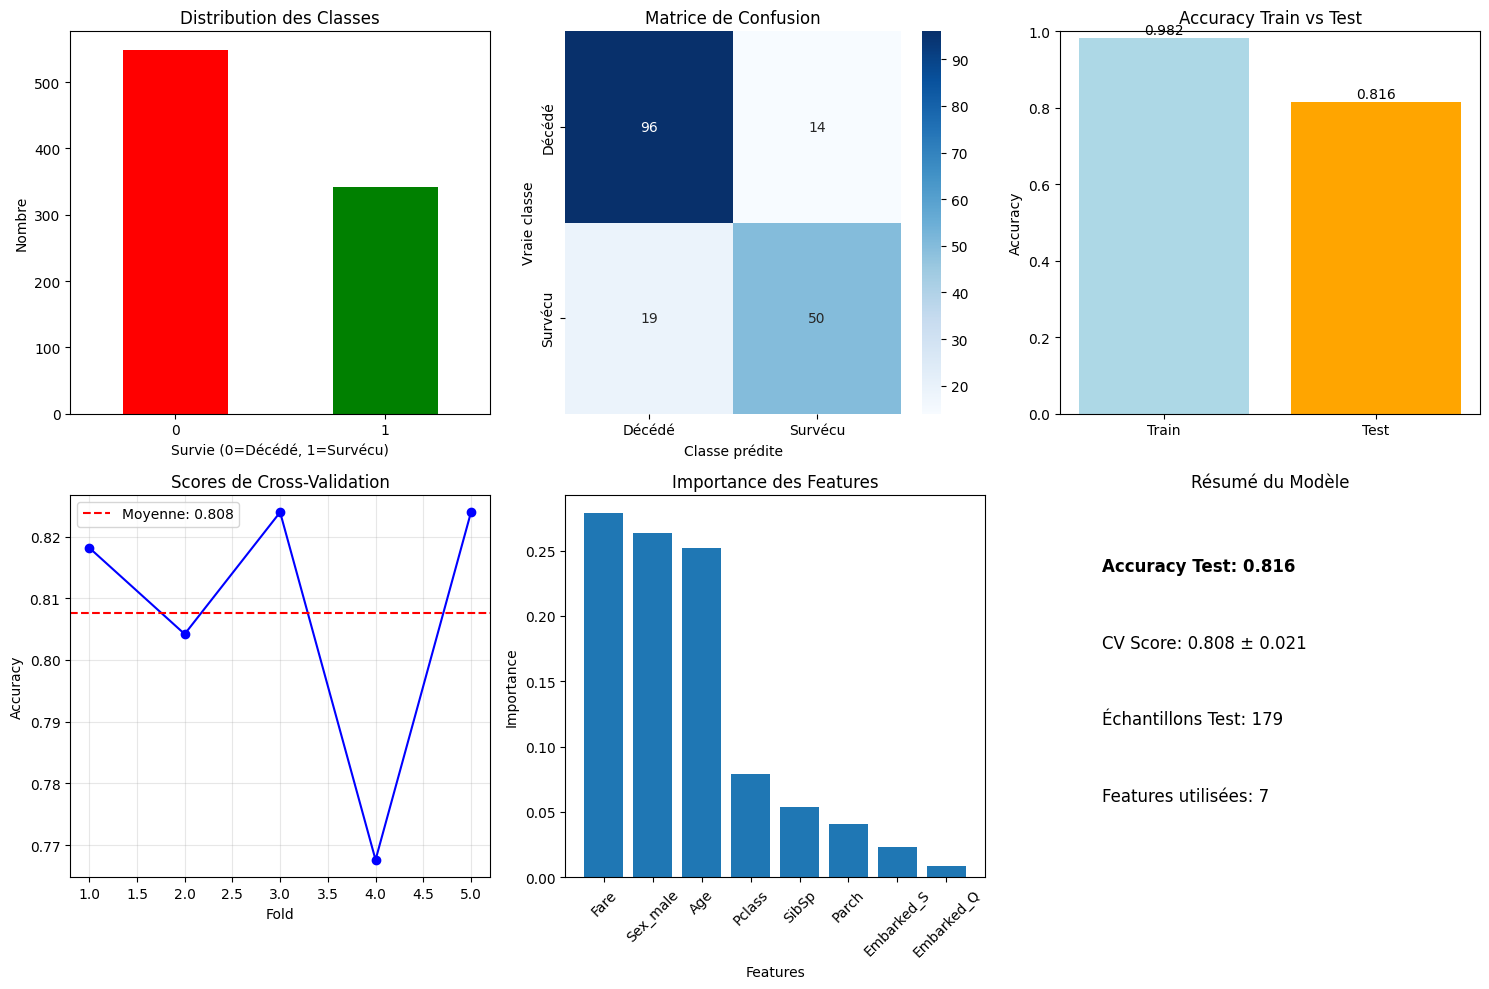


RÉSUMÉ DU PROJET ML
Dataset: Titanic (891 passagers)
Tâche: Classification binaire (survie)
Modèle: Random Forest
Features: 7 variables
Accuracy finale: 0.816
Score CV: 0.808 ± 0.021

=== EXEMPLE DE PRÉDICTION ===
Nouveau passager: Femme, 29 ans, 1ère classe
Prédiction: Survécu
Probabilités: Décès=0.00%, Survie=100.00%


In [51]:
# 11. VISUALISATION DES RÉSULTATS
print("\n=== VISUALISATION ===")

# Configuration des graphiques
plt.figure(figsize=(15, 10))

# 1. Distribution des classes
plt.subplot(2, 3, 1)
y.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribution des Classes')
plt.ylabel('Nombre')
plt.xlabel('Survie (0=Décédé, 1=Survécu)')
plt.xticks(rotation=0)

# 2. Matrice de confusion (heatmap)
plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Décédé', 'Survécu'],
            yticklabels=['Décédé', 'Survécu'])
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')

# 3. Comparaison Train vs Test
plt.subplot(2, 3, 3)
scores = [train_accuracy, test_accuracy]
labels = ['Train', 'Test']
colors = ['lightblue', 'orange']
plt.bar(labels, scores, color=colors)
plt.title('Accuracy Train vs Test')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

# 4. Scores de Cross-Validation
plt.subplot(2, 3, 4)
plt.plot(range(1, len(cv_scores) + 1), cv_scores, 'bo-')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
            label=f'Moyenne: {cv_scores.mean():.3f}')
plt.title('Scores de Cross-Validation')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Feature Importance (si disponible)
if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
    plt.subplot(2, 3, 5)
    feature_names = numerical_features + categorical_features
    importances = model_pipeline.named_steps['classifier'].feature_importances_
        
    # Récupérer les vrais noms de features après transformation
    preprocessor = model_pipeline.named_steps['preprocessor']
    num_features = preprocessor.transformers_[0][2]
    cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
    cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
    feature_names_full = list(num_features) + list(cat_features)

    # Tri par importance
    indices = np.argsort(importances)[::-1]
    
    plt.bar(range(len(importances)), importances[indices])
    plt.title('Importance des Features')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(range(len(importances)), 
               [feature_names_full[i] for i in indices], rotation=45)

# 6. Résumé des métriques
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, f'Accuracy Test: {test_accuracy:.3f}', fontsize=12, fontweight='bold')
plt.text(0.1, 0.6, f'CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}', fontsize=12)
plt.text(0.1, 0.4, f'Échantillons Test: {len(y_test)}', fontsize=12)
plt.text(0.1, 0.2, f'Features utilisées: {len(feature_names)}', fontsize=12)
plt.title('Résumé du Modèle')
plt.axis('off')

plt.tight_layout()
plt.show()

# 12. RÉSUMÉ FINAL
print("\n" + "="*50)
print("RÉSUMÉ DU PROJET ML")
print("="*50)
print(f"Dataset: Titanic ({df.shape[0]} passagers)")
print(f"Tâche: Classification binaire (survie)")
print(f"Modèle: Random Forest")
print(f"Features: {len(feature_names)} variables")
print(f"Accuracy finale: {test_accuracy:.3f}")
print(f"Score CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print("="*50)

# Exemple de prédiction sur de nouveaux données
print("\n=== EXEMPLE DE PRÉDICTION ===")
nouveau_passager = pd.DataFrame({
    'Pclass': [1],
    'Sex': ['female'],
    'Age': [29],
    'SibSp': [0],
    'Parch': [0],
    'Fare': [80],
    'Embarked': ['C']
})

prediction = model_pipeline.predict(nouveau_passager)[0]
proba = model_pipeline.predict_proba(nouveau_passager)[0]

print(f"Nouveau passager: Femme, 29 ans, 1ère classe")
print(f"Prédiction: {'Survécu' if prediction == 1 else 'Décédé'}")
print(f"Probabilités: Décès={proba[0]:.2%}, Survie={proba[1]:.2%}")